In [1]:
"""
This model is "shoe, sandal, slipper detector"

"""

import os
import cv2
import numpy as np
import sys
import pickle
from optparse import OptionParser
import time
from keras_frcnn import config
import keras_frcnn.resnet as nn
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
import random
from keras.utils import plot_model
import pydot

sys.setrecursionlimit(40000)

config_output_filename = "model_frcnn_11.pickle"

with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

class_mapping = C.class_mapping

if 'bg' not in class_mapping:
    class_mapping['bg'] = len(class_mapping)
class_mapping = {v: k for k, v in class_mapping.items()}
C.num_rois = 32

if K.image_dim_ordering() == 'th':
    input_shape_img = (3, None, None)
    input_shape_features = (1024, None, None)
else:
    input_shape_img = (None, None, 3)
    input_shape_features = (None, None, 1024)


img_input = Input(shape=input_shape_img)
roi_input = Input(shape=(C.num_rois, 4))
feature_map_input = Input(shape=input_shape_features)

# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
rpn_layers = nn.rpn(shared_layers, num_anchors)

classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

model_rpn = Model(img_input, rpn_layers)
model_classifier = Model([feature_map_input, roi_input], classifier)

model_rpn.load_weights(C.model_path, by_name=True)
model_classifier.load_weights(C.model_path, by_name=True)

model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

model_classifier_layer_dict = dict([(layer.name, layer) for layer in model_classifier.layers])
model_rpn_layer_dict = dict([(layer.name, layer) for layer in model_rpn.layers])


Using TensorFlow backend.


In [2]:
model_rpn_layer_dict
# for a in model_rpn_layer_dict:
#     print(a)

{'activation_1': <keras.layers.core.Activation at 0x7f6351f3f8d0>,
 'activation_10': <keras.layers.core.Activation at 0x7f6351c94790>,
 'activation_11': <keras.layers.core.Activation at 0x7f6351bf4b10>,
 'activation_12': <keras.layers.core.Activation at 0x7f6351bc0790>,
 'activation_13': <keras.layers.core.Activation at 0x7f6351b3a950>,
 'activation_14': <keras.layers.core.Activation at 0x7f6351b1bcd0>,
 'activation_15': <keras.layers.core.Activation at 0x7f6351ae7950>,
 'activation_16': <keras.layers.core.Activation at 0x7f6351aa7510>,
 'activation_17': <keras.layers.core.Activation at 0x7f6351a09490>,
 'activation_18': <keras.layers.core.Activation at 0x7f6351a2fd90>,
 'activation_19': <keras.layers.core.Activation at 0x7f635197d890>,
 'activation_2': <keras.layers.core.Activation at 0x7f6351f0ba10>,
 'activation_20': <keras.layers.core.Activation at 0x7f635195ac10>,
 'activation_21': <keras.layers.core.Activation at 0x7f635192b890>,
 'activation_22': <keras.layers.core.Activation at

In [3]:
for i, layer in enumerate(model_rpn.layers):
    print(i, layer.name)

(0, 'input_1')
(1, 'zero_padding2d_1')
(2, 'conv1')
(3, 'bn_conv1')
(4, 'activation_1')
(5, 'max_pooling2d_1')
(6, 'res2a_branch2a')
(7, 'bn2a_branch2a')
(8, 'activation_2')
(9, 'res2a_branch2b')
(10, 'bn2a_branch2b')
(11, 'activation_3')
(12, 'res2a_branch2c')
(13, 'res2a_branch1')
(14, 'bn2a_branch2c')
(15, 'bn2a_branch1')
(16, 'add_1')
(17, 'activation_4')
(18, 'res2b_branch2a')
(19, 'bn2b_branch2a')
(20, 'activation_5')
(21, 'res2b_branch2b')
(22, 'bn2b_branch2b')
(23, 'activation_6')
(24, 'res2b_branch2c')
(25, 'bn2b_branch2c')
(26, 'add_2')
(27, 'activation_7')
(28, 'res2c_branch2a')
(29, 'bn2c_branch2a')
(30, 'activation_8')
(31, 'res2c_branch2b')
(32, 'bn2c_branch2b')
(33, 'activation_9')
(34, 'res2c_branch2c')
(35, 'bn2c_branch2c')
(36, 'add_3')
(37, 'activation_10')
(38, 'res3a_branch2a')
(39, 'bn3a_branch2a')
(40, 'activation_11')
(41, 'res3a_branch2b')
(42, 'bn3a_branch2b')
(43, 'activation_12')
(44, 'res3a_branch2c')
(45, 'res3a_branch1')
(46, 'bn3a_branch2c')
(47, 'bn3a_b

In [5]:
model_rpn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, None, None, 3) 0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, None, None, 64 9472                                         
____________________________________________________________________________________________________
bn_conv1 (FixedBatchNormalizatio (None, None, None, 64 256                                          
___________________________________________________________________________________________

In [6]:
model_classifier.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, None, None, 10 0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 32, 4)         0                                            
____________________________________________________________________________________________________
roi_pooling_conv_1 (RoiPoolingCo (None, 32, 14, 14, 10 0                                            
____________________________________________________________________________________________________
res5a_branch2a (TimeDistributed) (None, 32, 7, 7, 512) 524800                                       
___________________________________________________________________________________________

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline
fig_size  = np.array([24,18])
# fig_size[0] = 12
# fig_size[1] = 9
plt.rcParams["figure.figsize"] = fig_size

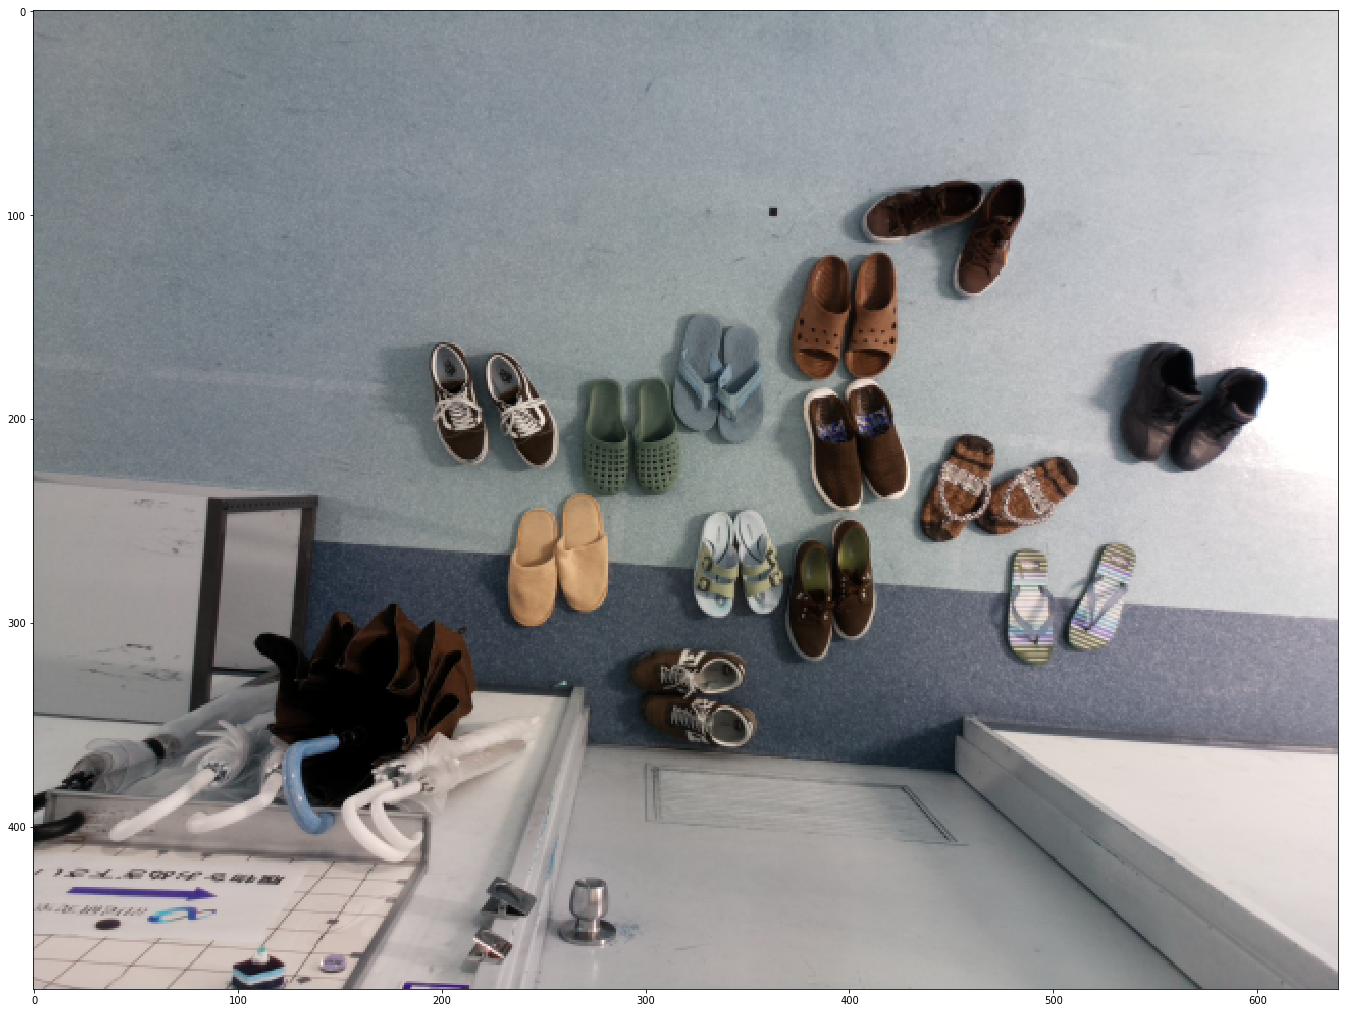

In [31]:
# input img
def load_img(fileName):
    #prepare input picture
    im = cv2.imread(fileName)
    if im is None:
        print("no image file selected")
    # im=cv2.resize(im, (56,56))
    imNP = np.asarray(im)
    a= [imNP.reshape(-1,imNP.shape[0],imNP.shape[1],imNP.shape[2]), 0]
    plt.imshow(im)
    return a
np_img = load_img("1.png")

The second dimension tells us how many convolutions do we have: (1, 30, 40, 1024) (30 convolutions)
(1, 30, 40, 1024)


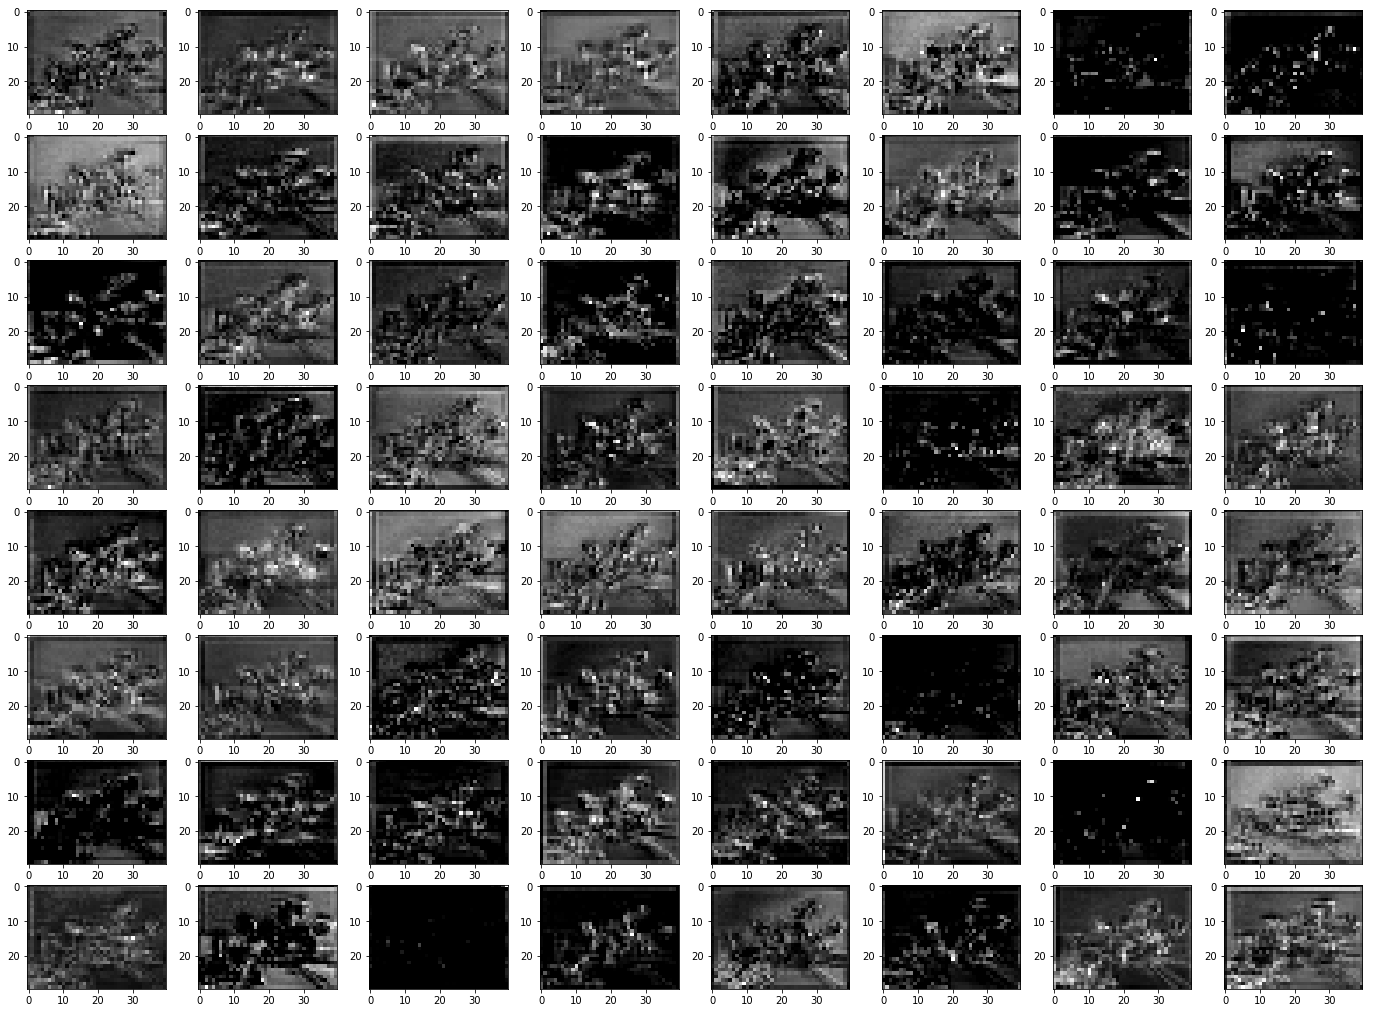

In [29]:
indeex = 141
layer_output = K.function([model_rpn.layers[0].input, K.learning_phase()], [model_rpn.layers[indeex].output])
layer_output = layer_output(np_img)[0]

print('The second dimension tells us how many convolutions do we have: %s (%d convolutions)' % (str(layer_output.shape),layer_output.shape[1]))
print(layer_output.shape)
numberConvolution=layer_output.shape[3]
b= int(numberConvolution/8)
a= int(numberConvolution/b)

i=1
fig = plt.figure() 
fig.canvas.set_window_title('My Window Title') 
# print("layer_output =")
# print(layer_output.shape)
# one_filter_output = np.rollaxis(layer_output, 3)[0]
# plt.imshow(one_filter_output[0],'gray')

for onePic in np.rollaxis(layer_output, 3):
#     if filterNum is 1:
#         plt.subplot(2, 1, 1)
#         plt.imshow(onePic[0], 'gray')
#         continue    
#     if filterNum is 2:
#         plt.subplot(2, 1, 2)
#         plt.imshow(onePic[0], 'gray')
#         continue
    if i > 64:
        break
    
    plt.subplot(8, 8, i)
    plt.imshow(onePic[0], 'gray')
    i= i+1
    
plt.show()


In [37]:
# layer_output = K.function([model_rpn.layers[0].input, K.learning_phase()], [model_rpn_layer_dict['rpn_conv1']])
indeex = 34
layer_output = K.function([model_classifier.layers[0].input, K.learning_phase()], [model_classifier.layers[indeex].output])
layer_output = layer_output(np_img)[0]

print('The second dimension tells us how many convolutions do we have: %s (%d convolutions)' % (str(layer_output.shape),layer_output.shape[1]))
print(layer_output.shape)
numberConvolution=layer_output.shape[3]
b= int(numberConvolution/8)
a= int(numberConvolution/b)

i=1
fig = plt.figure() 
fig.canvas.set_window_title('My Window Title') 
print("layer_output =")
print(layer_output.shape)
one_filter_output = np.rollaxis(layer_output, 3)[0]
plt.imshow(one_filter_output[0],'gray')

for onePic in np.rollaxis(layer_output, 3):
#     if filterNum is 1:
#         plt.subplot(2, 1, 1)
#         plt.imshow(onePic[0], 'gray')
#         continue    
#     if filterNum is 2:
#         plt.subplot(2, 1, 2)
#         plt.imshow(onePic[0], 'gray')
#         continue
    if i > 64:
        break
    
    plt.subplot(8, 8, i)
    plt.imshow(onePic[0], 'gray')
    i= i+1
plt.show()

ValueError: Cannot feed value of shape (1, 480, 640, 3) for Tensor u'input_9:0', which has shape '(?, ?, ?, 1024)'

In [16]:
def show_activation(indeex, target_model, input_img_np, filter_num=64):

    # layer_output = K.function([model_rpn.layers[0].input, K.learning_phase()], [model_rpn_layer_dict['rpn_conv1']])

    layer_output = K.function([model_rpn.layers[0].input, K.learning_phase()], [target_model.layers[indeex].output])
    layer_output = layer_output(input_img_np)[0]

    print('The second dimension tells us how many convolutions do we have: %s (%d convolutions)' % (str(layer_output.shape),layer_output.shape[1]))
    print(layer_output.shape)
    
    numberConvolution=layer_output.shape[3]
    b= int(numberConvolution/8)
    a= int(numberConvolution/b)

    i=1
    fig = plt.figure() 
    fig.canvas.set_window_title('My Window Title') 

    for onePic in np.rollaxis(layer_output, 3):

        if i > 64:
            break

        plt.subplot(8, 8, i)
        plt.imshow(onePic[0], 'gray')
        i= i+1

    plt.show()
    return layer_output


The second dimension tells us how many convolutions do we have: (1, 30, 40, 1024) (30 convolutions)
(1, 30, 40, 1024)


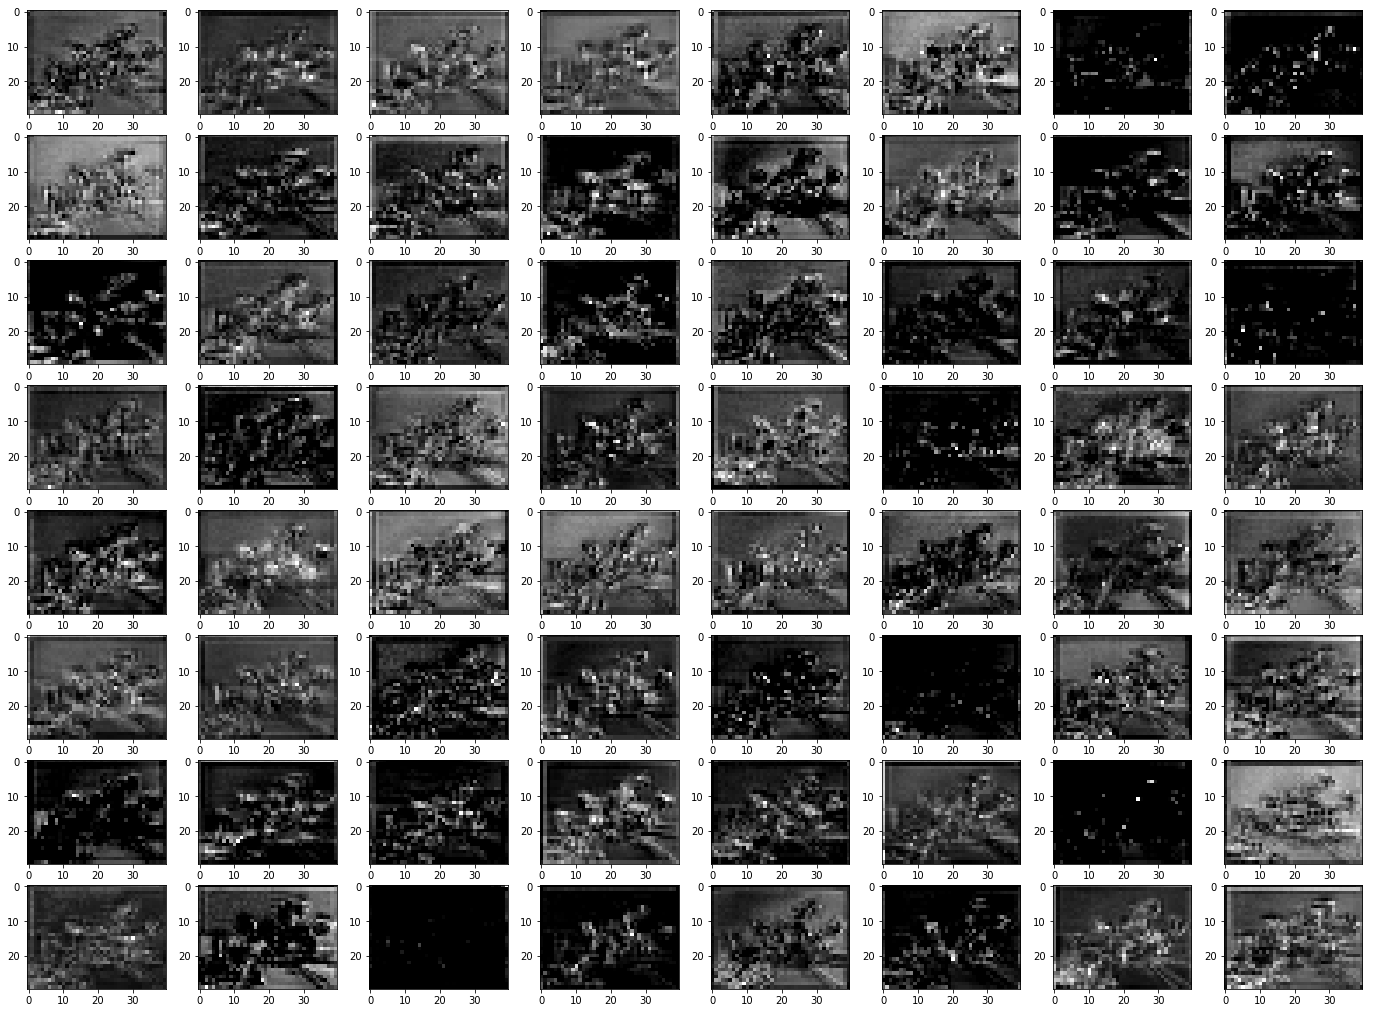

In [12]:
show_activation(indeex = 141, target_model = model_rpn, input_img_np=np_img, filter_num=64)

The second dimension tells us how many convolutions do we have: (1, 30, 40, 512) (30 convolutions)
(1, 30, 40, 512)


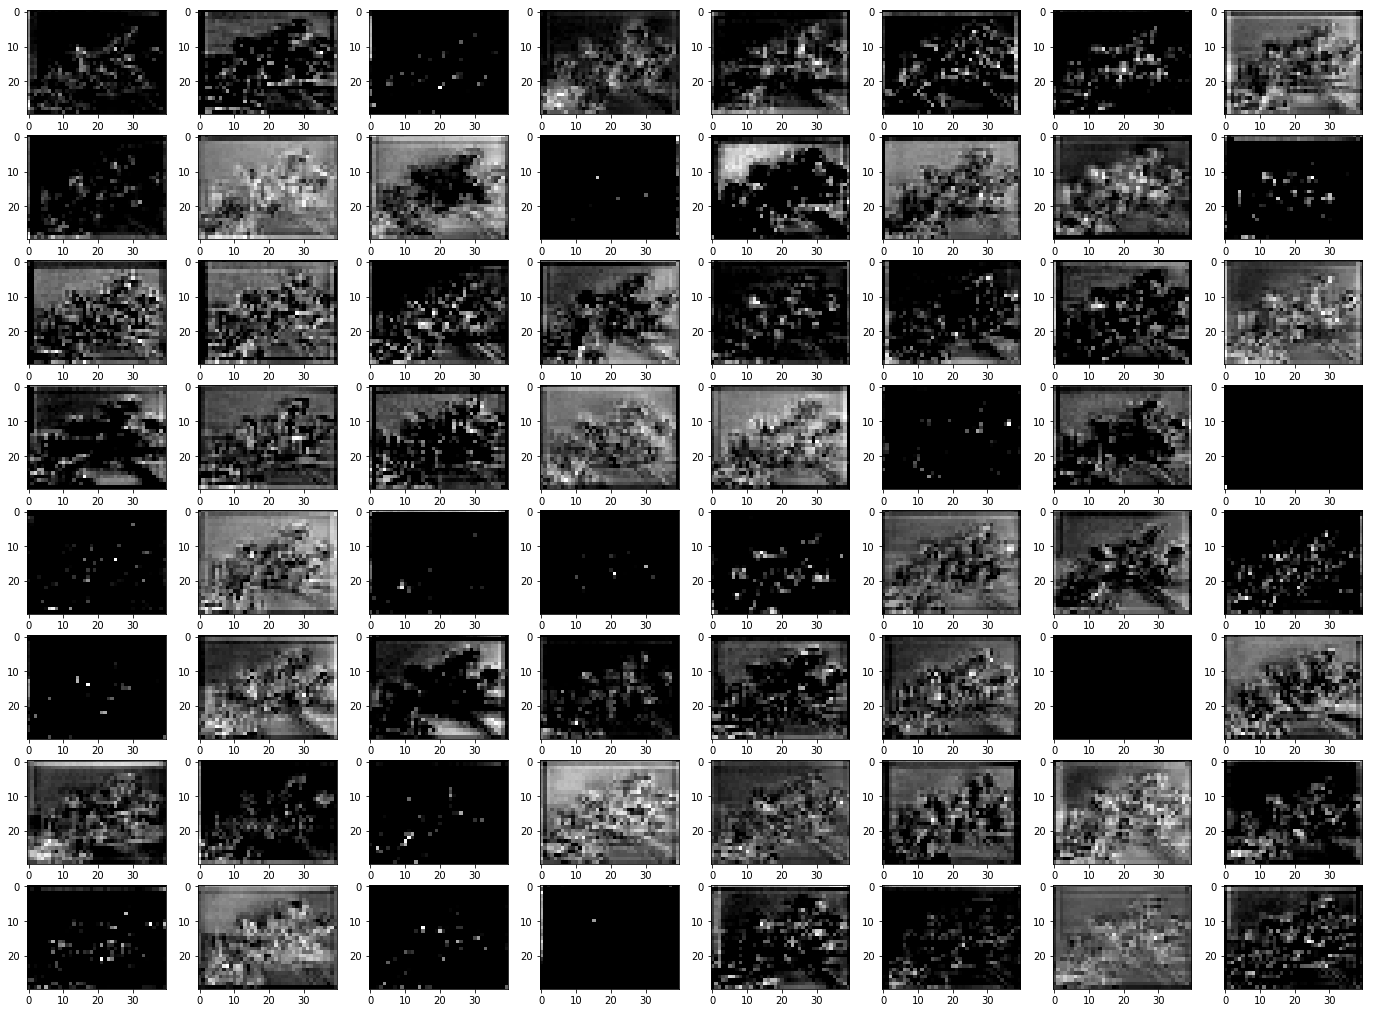

In [13]:
show_activation(indeex = 142, target_model = model_rpn, input_img_np=np_img, filter_num=64)

The second dimension tells us how many convolutions do we have: (1, 30, 40, 9) (30 convolutions)
(1, 30, 40, 9)


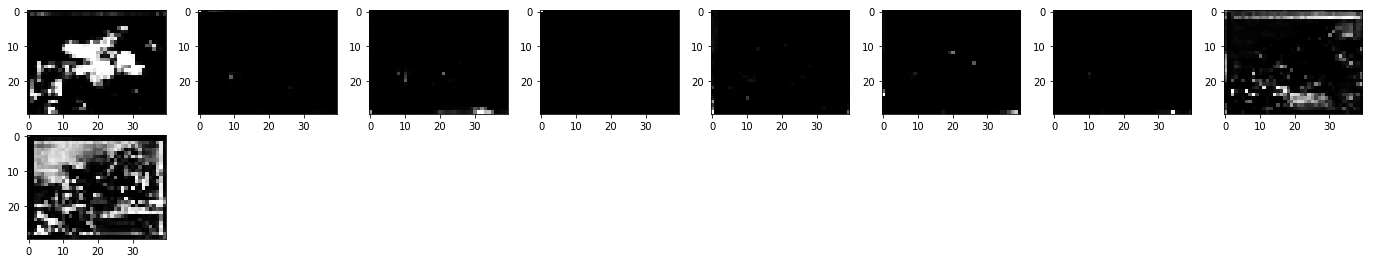

In [17]:
cls_output = show_activation(indeex = 143, target_model = model_rpn, input_img_np=np_img, filter_num=64)

The second dimension tells us how many convolutions do we have: (1, 30, 40, 36) (30 convolutions)
(1, 30, 40, 36)


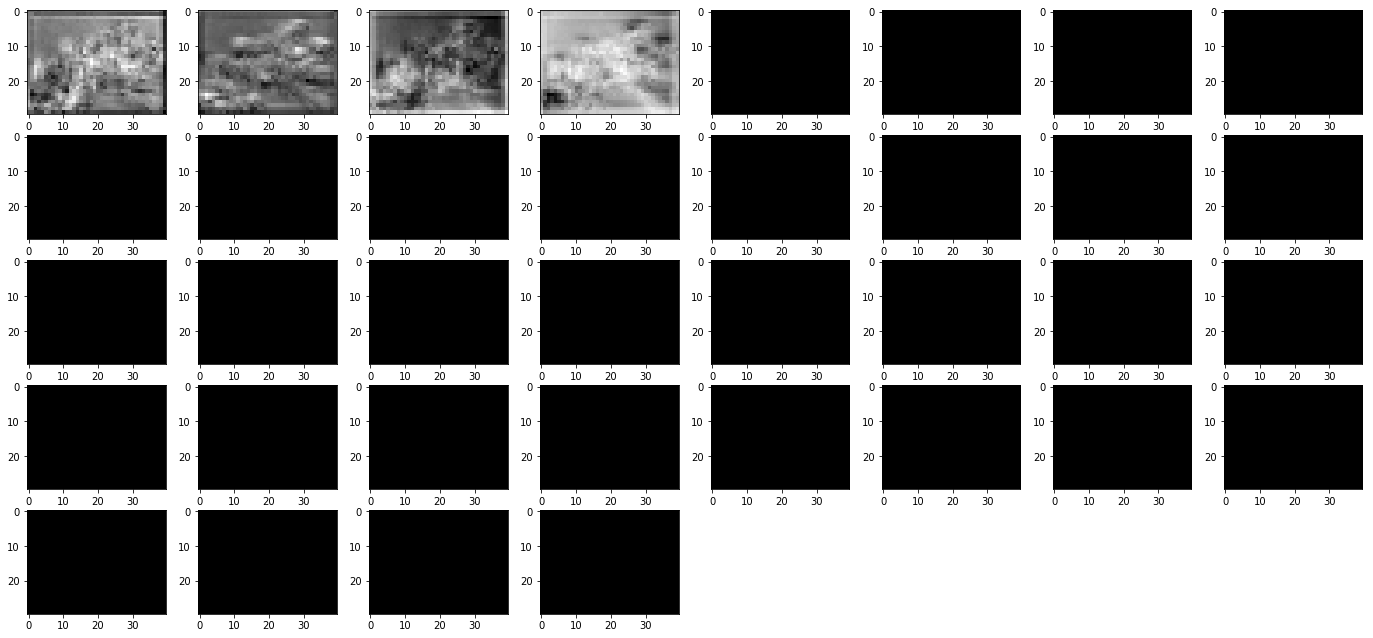

In [18]:
reg_output = show_activation(indeex = 144, target_model = model_rpn, input_img_np=np_img, filter_num=64)

In [45]:
cls_output[0]
np.rollaxis(cls_output, 3).shape
np.max(np.rollaxis(cls_output, 3)[0][0])


# enenii zahyog olood, zurgiin printlej gargaj boloh ym.

1.0

In [18]:
indeex = 144
target_model = model_rpn
input_img_np=np_img
filter_num=64

layer_output = K.function([model_rpn.layers[0].input, K.learning_phase()], [target_model.layers[indeex].output])
layer_output = layer_output(input_img_np)[0]

print('The second dimension tells us how many convolutions do we have: %s (%d convolutions)' % (str(layer_output.shape),layer_output.shape[1]))
print(layer_output.shape)

numberConvolution=layer_output.shape[3]
b= int(numberConvolution/8)
a= int(numberConvolution/b)

i=1
fig = plt.figure()
fig.canvas.set_window_title('My Window Title') 

for onePic in np.rollaxis(layer_output, 3):
    if i > 64:
        break
    plt.subplot(8, 8, i)
    plt.imshow(onePic[0], 'gray')
    i= i+1

plt.show()